## Jupyter Notebook para desarrollar la Task 3

Sistema de recomendación de 5 productos para cada sesión nueva.

Lectura de los DataFrames:

In [2]:
from pathlib import Path    
import pandas as pd

RAW_DATA_PATH = Path('../../data/raw')

train_df = pd.read_csv(         RAW_DATA_PATH / 'train.csv')
test_df = pd.read_csv(          RAW_DATA_PATH / 'test.csv')
products_df = pd.read_pickle(   RAW_DATA_PATH / 'products.pkl')
users_df = pd.read_csv(         RAW_DATA_PATH / 'users_data.csv')

In [3]:
import ast

# Extraer datos del string (JSON) de la columna 'values'
def extract_data_from_string(df, column_name):
    
    df[column_name] = df[column_name].apply(ast.literal_eval)
    
    df['country'] = df[column_name].apply(lambda x: x['country'])
    df['R'] = df[column_name].apply(lambda x: x['R'])
    df['F'] = df[column_name].apply(lambda x: x['F'])
    df['M'] = df[column_name].apply(lambda x: x['M'])
    
    df = df.drop(columns=[column_name])
    
    df = df.explode(['country', 'R', 'F', 'M'])
    
    df['country'] = df['country'].astype(int)
    df['R'] = df['R'].astype(int)
    df['F'] = df['F'].astype(int)
    df['M'] = df['M'].astype(float)
    
    return df

users_df = extract_data_from_string(users_df, 'values')

In [4]:
import pandas as pd
import numpy as np

# Products DataFrame Processing
products_df['discount'] = products_df['discount'].astype(int)
products_df['cod_section'] = products_df['cod_section'].fillna(products_df['cod_section'].median()).astype(int)

# Train DataFrame Processing
train_df['user_id'] = train_df['user_id'].fillna(0).astype(int)
train_df['timestamp_local'] = pd.to_datetime(train_df['timestamp_local'])
train_df['pagetype'] = train_df['pagetype'].fillna(train_df['pagetype'].mode()[0]).astype(int)

test_df['user_id'] = test_df['user_id'].fillna(0).astype(int)
test_df['timestamp_local'] = pd.to_datetime(test_df['timestamp_local'])
test_df['pagetype'] = test_df['pagetype'].fillna(test_df['pagetype'].mode()[0]).astype(int)

# Verify conversions
print("Users DataFrame dtypes:\n", users_df.dtypes)
print("\nTrain DataFrame dtypes:\n", train_df.dtypes)
print("\nTest DataFrame dtypes:\n", test_df.dtypes)
print("\nProducts DataFrame dtypes:\n", products_df.dtypes)

Users DataFrame dtypes:
 user_id      int64
country      int32
R            int32
F            int32
M          float64
dtype: object

Train DataFrame dtypes:
 session_id                  int64
date                       object
timestamp_local    datetime64[ns]
add_to_cart                 int64
user_id                     int32
country                     int64
partnumber                  int64
device_type                 int64
pagetype                    int32
dtype: object

Test DataFrame dtypes:
 session_id                  int64
date                       object
timestamp_local    datetime64[ns]
user_id                     int32
country                     int64
partnumber                  int64
device_type                 int64
pagetype                    int32
dtype: object

Products DataFrame dtypes:
 discount        int32
embedding      object
partnumber      int32
color_id        int32
cod_section     int32
family          int32
dtype: object


In [5]:
# Convertimos las variables a categoricas, nos conviene para que el modelo las interprete como tal
users_df['country'] = users_df['country'].astype('category')

categorical_cols_train = ['device_type', 'pagetype', 'country']
for col in categorical_cols_train:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

categorical_cols_products = ['color_id', 'cod_section', 'family']
for col in categorical_cols_products:
    products_df[col] = products_df[col].astype('category')

print("Users DataFrame dtypes:\n", users_df.dtypes)
print("\nTrain DataFrame dtypes:\n", train_df.dtypes)
print("\nTest DataFrame dtypes:\n", test_df.dtypes)
print("\nProducts DataFrame dtypes:\n", products_df.dtypes)

Users DataFrame dtypes:
 user_id       int64
country    category
R             int32
F             int32
M           float64
dtype: object

Train DataFrame dtypes:
 session_id                  int64
date                       object
timestamp_local    datetime64[ns]
add_to_cart                 int64
user_id                     int32
country                  category
partnumber                  int64
device_type              category
pagetype                 category
dtype: object

Test DataFrame dtypes:
 session_id                  int64
date                       object
timestamp_local    datetime64[ns]
user_id                     int32
country                  category
partnumber                  int64
device_type              category
pagetype                 category
dtype: object

Products DataFrame dtypes:
 discount          int32
embedding        object
partnumber        int32
color_id       category
cod_section    category
family         category
dtype: object


In [6]:
# El user_id trae muchos valores nulos, por lo que se nos ocurre crear dos nuevos ids user_id, session_id sin colisiones entre ellos.
# El objetivo es reeplazar los nulos en user_id por el session_id, de forma que si no tenemos el dato de usuario, al menos
#     somos capaces de relacionar registros por sesión (supongamos, por ejemplo que son usuarios no registrados en la web)

# Usamos columnas temporales para crear los nuevos
users_df['temp_user_id'] = users_df['user_id'] * 10
train_df['temp_session_id'] = train_df['session_id'] * 10 + 1
train_df['temp_user_id'] = train_df['user_id'] * 10
test_df['temp_session_id'] = test_df['session_id'] * 10 + 1
test_df['temp_user_id'] = test_df['user_id'] * 10

train_df.loc[train_df['temp_user_id'] == 0, 'temp_user_id'] = train_df.loc[train_df['temp_user_id'] == 0, 'temp_session_id'].astype('int32')
test_df.loc[test_df['temp_user_id'] == 0, 'temp_user_id'] = test_df.loc[test_df['temp_user_id'] == 0, 'temp_session_id'].astype('int32')

users_df['user_id'] = users_df['temp_user_id']
train_df['session_id'] = train_df['temp_session_id']
train_df['user_id'] = train_df['temp_user_id']
test_df['session_id'] = test_df['temp_session_id']
test_df['user_id'] = test_df['temp_user_id']

users_df.drop('temp_user_id', axis=1, inplace=True)
train_df.drop(['temp_session_id', 'temp_user_id'], axis=1, inplace=True)
test_df.drop(['temp_session_id', 'temp_user_id'], axis=1, inplace=True)

# Print, y verificar que no hay colisiones entre los ids.
print(train_df[['session_id', 'user_id']].head())
print(test_df[['session_id', 'user_id']].head())
print(users_df['user_id'].head())

print("\nExisten colisiones:", 
      bool(set(users_df['user_id']).intersection(set(train_df['session_id']))))

   session_id  user_id
0         641      641
1        1171     1171
2        1171     1171
3        5791     5791
4       12201  4807290
   session_id  user_id
0        7461     7461
1        7461     7461
2        7461     7461
3        7461     7461
4        7461     7461
0    1803480
1    1754230
1    1754230
2    1803490
3    1803500
Name: user_id, dtype: int64

Existen colisiones: False


In [7]:
def add_user_features(df: pd.DataFrame) -> pd.DataFrame:
    """Añadimos variables de interés calculadas a nivel de user_id"""
    
    print("Transformamos timestamps...")
    df['total_seconds'] = df['timestamp_local'].astype(np.int64) // 1e9
    df['hour'] = df['timestamp_local'].dt.hour
    
    print("Agrupamos por user_id...")
    grouped = df.groupby('user_id', observed=True).agg({
        'partnumber': 'nunique',
        'pagetype': 'nunique',
        'total_seconds': ['min', 'max'],
        'hour': 'first',
        'user_id': 'size' # Interacciones
    }).reset_index()
    
    grouped.columns = ['user_id', 'unique_products', 'unique_pagetypes', 
                      'min_time', 'max_time', 'first_interaction_hour',
                      'total_interactions']
    
    # Calculamos el tiempo
    grouped['total_user_time'] = (grouped['max_time'] - grouped['min_time']).round(2)
    grouped = grouped.drop(['min_time', 'max_time'], axis=1)
    
    # Merge
    print("Merging results...")
    result = df.merge(grouped, on='user_id')
    
    return result

In [8]:
train_df = add_user_features(train_df)
test_df = add_user_features(test_df)

Transformamos timestamps...
Agrupamos por user_id...
Merging results...
Transformamos timestamps...
Agrupamos por user_id...
Merging results...


In [9]:
# Añadiremos tres columnas, el ratio de exito del usuario con el producto, el ratio de exito global del producto, y el numero de veces que se ha añadido al carrito globalmente cada producto.
user_product_metrics = (
    train_df
    .groupby(['user_id', 'partnumber'])
    .agg({
        'add_to_cart': ['sum', 'count']
    })
    .reset_index()
)

user_product_metrics.columns = ['user_id', 'partnumber', 'adds_to_cart', 'total_visits']
user_product_metrics['success_rate'] = user_product_metrics['adds_to_cart'] / user_product_metrics['total_visits']

train_df = train_df.merge(
    user_product_metrics[['user_id', 'partnumber', 'success_rate']], 
    on=['user_id', 'partnumber'], 
    how='left'
)

product_metrics = (
    train_df
    .groupby('partnumber')
    .agg({
        'add_to_cart': ['sum', 'count']
    })
    .reset_index()
)

product_metrics.columns = ['partnumber', 'total_adds_to_cart', 'total_visits']
product_metrics['global_success_rate'] = product_metrics['total_adds_to_cart'] / product_metrics['total_visits']

products_df = products_df.merge(
    product_metrics[['partnumber', 'total_adds_to_cart', 'global_success_rate', 'total_visits']], 
    on='partnumber', 
    how='left'
)

# Cubrimos nulos
train_df['success_rate'] = train_df['success_rate'].fillna(0)
products_df['total_adds_to_cart'] = products_df['total_adds_to_cart'].fillna(0)
products_df['global_success_rate'] = products_df['global_success_rate'].fillna(0)
products_df['total_visits'] = products_df['total_visits'].fillna(0)

In [10]:
# Añadimos el historial de usuario
user_history = (
    train_df
    .groupby('user_id')
    .agg(
        avg_success_rate_per_user=('success_rate', 'mean'),
        num_unique_products_interacted=('partnumber', 'nunique')
    )
    .reset_index()
)

users_df = users_df.merge(
    user_history, 
    on='user_id', 
    how='left'
)

# Cubrimos nulos
users_df['avg_success_rate_per_user'] = users_df['avg_success_rate_per_user'].fillna(0)
users_df['num_unique_products_interacted'] = users_df['num_unique_products_interacted'].fillna(0)

In [11]:
import pandas as pd

# Filtramos solo compras reales
train_purchases = train_df[train_df["add_to_cart"] == 1]

# Contamos cuántas veces ha comprado cada usuario un producto antes de cada fila
train_df["user_has_bought_product_before"] = (
    train_purchases.groupby(["user_id", "partnumber"]).cumcount()
    .astype("int8")
)

# Convertimos a 0/1: Si hay al menos una compra previa → 1, si no → 0
train_df["user_has_bought_product_before"] = (train_df["user_has_bought_product_before"] > 0).astype("int8").astype('category')

# Creamos un set de pares (usuario, producto) que han comprado en train_df
user_product_bought = set(zip(train_purchases["user_id"], train_purchases["partnumber"]))

# Aplicamos la marca en test_df
test_df["user_has_bought_product_before"] = test_df.apply(
    lambda row: 1 if (row["user_id"], row["partnumber"]) in user_product_bought else 0,
    axis=1
).astype("int8").astype('category')

In [ ]:
def analyze_dataframes(dfs_dict):
    for name, df in dfs_dict.items():
        print(f"\n{'='*20} {name} Analysis {'='*20}")
        
        print(f"\nShape: {df.shape}")
        print(f"Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
        
        print("\nColumns and Types:")
        print(df.dtypes)
        
        print("\nMissing Values:")
        print(df.isnull().sum())

        print("\nNumerical Columns Statistics:")
        print(df.describe())
        
        print("\nSample Data:")
        print(df.head())

dfs = {
    'Train': train_df,
    'Test': test_df,
    'Users': users_df,
    'Products': products_df
}

analyze_dataframes(dfs)

## Entrenamiento del modelo: Versión 1

In [15]:
import pandas as pd

def prepare_features(df, users_df, products_df):
    
    # Temporales
    df['hour'] = pd.to_datetime(df['timestamp_local']).dt.hour.astype('int8')

    # Merge de los datasets
    df = df.merge(users_df[['user_id', 'country', 
                            'R', 'F', 'M', 
                            'avg_success_rate_per_user', 'num_unique_products_interacted']], on=['user_id','country'], how='left')
    df = df.merge(products_df[['partnumber', 'discount', 'family', 'color_id', 'cod_section', 'total_adds_to_cart', 'global_success_rate', 'total_visits']], on='partnumber', how='left')

    features = ['hour', 'country', 'device_type', 'pagetype', 
                'family', 'color_id', 'cod_section', 'total_adds_to_cart', 'global_success_rate', 'total_visits', 'avg_success_rate_per_user', 'num_unique_products_interacted',
                'R', 'F', 'M', 'discount', 'total_seconds', 
                'unique_products', 'unique_pagetypes', 'total_interactions', 'total_user_time',
                'user_has_bought_product_before']

    return df[features]

# Prepare train and test data
X_train = prepare_features(train_df, users_df, products_df)
y_train = train_df['success_rate']
X_test = prepare_features(test_df, users_df, products_df)

In [16]:
from lightgbm import LGBMRegressor, LGBMClassifier

# Entrenamos el modelo
model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

# Prediccion
test_df['predicted_success_rate'] = model.predict(X_test)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.448826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3589
[LightGBM] [Info] Number of data points in the train set: 46551445, number of used features: 22
[LightGBM] [Info] Start training from score 0.058984


### Grid Search 

In [13]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# Define the model
model = LGBMRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [5, 7]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=3, n_jobs=4)
grid_search.fit(X_train[:500000], y_train[:500000])

# Print the best parameters
print(f"Best parameters found by GridSearchCV: {grid_search.best_params_}")

# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Prediction
test_df['predicted_success_rate'] = best_model.predict(X_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3392
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 22
[LightGBM] [Info] Start training from score 0.058929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

### Predicciones y resultados

🔍 Top 10 Features más importantes:
                      Feature  Importance
17            unique_products         836
10  avg_success_rate_per_user         761
19         total_interactions         685
20            total_user_time         636
8         global_success_rate         597
5                    color_id         453
1                     country         379
4                      family         332
3                    pagetype         290
18           unique_pagetypes         276

⚠️ Features con menor importancia:
                           Feature  Importance
21  user_has_bought_product_before         113
7               total_adds_to_cart         100
9                     total_visits          81
6                      cod_section          67
16                   total_seconds          65
0                             hour          45
15                        discount          10
13                               F           5
14                               M          

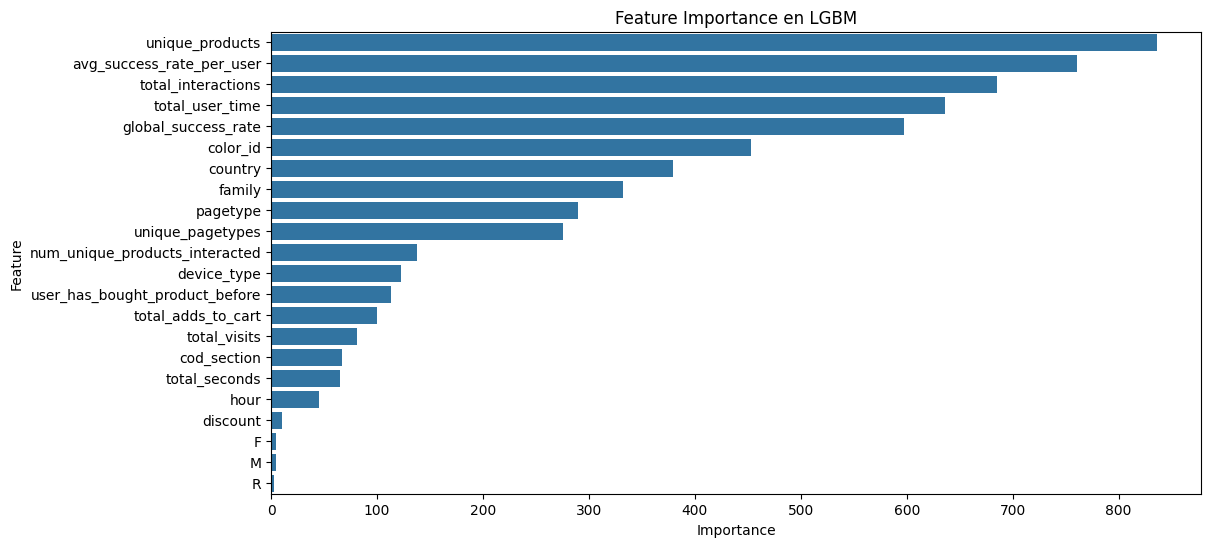

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Obtener importancia de cada feature
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Mostrar las 10 features más importantes
print("🔍 Top 10 Features más importantes:")
print(feature_importance.head(10))

# Mostrar las 10 menos importantes
print("\n⚠️ Features con menor importancia:")
print(feature_importance.tail(10))

# Graficar la importancia de las features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance en LGBM')
plt.show()


Matriz de productos similares y productos populares globalmente para mejorar recomendaciones.

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import json
from pathlib import Path

popular_products = (
    products_df
    .sort_values('global_success_rate', ascending=False)
    ['partnumber']
    .tolist()
)

# Convertimos embeddings de productos en una matriz
products_df['embedding'] = products_df['embedding'].apply(lambda x: x if x is not None else np.zeros(1280))
embedding_matrix = np.vstack(products_df['embedding'].values)

# Calculamos similitudes entre productos
similarity_matrix = cosine_similarity(embedding_matrix)

# Mapeamos cada producto con sus 5 más similares
product_indices = {p: i for i, p in enumerate(products_df['partnumber'])}
product_similarities = {
    partnumber: [
        products_df.iloc[idx]['partnumber'] 
        for idx in np.argsort(-similarity_matrix[product_indices[partnumber]])[1:6]  # Evita el mismo producto (posición 0)
    ]
    for partnumber in products_df['partnumber']
}

In [24]:
#Función para obtener productos similares
def get_similar_products(partnumber, k=3):
    return list(dict.fromkeys(product_similarities.get(partnumber, [])))[:k]

# Función de padding para asegurar 5 recomendaciones únicas
def pad_recommendations(prods):
    prods = list(dict.fromkeys(prods))  # Valores únicos
    
    if len(prods) >= 5:
        return prods[:5]

    # Añadimos productos similares si faltan recomendaciones
    similar_prods = []
    for p in prods:
        similar_prods.extend(get_similar_products(p, k=3))

    combined_prods = list(dict.fromkeys(prods + similar_prods))  # Valores únicos
    
    if len(combined_prods) >= 5:
        return combined_prods[:5]

    # Rellenamos con productos populares si aún faltan recomendaciones
    remaining = [p for p in popular_products if p not in combined_prods]
    final_recommendations = (combined_prods + remaining)[:5]

    return final_recommendations

Crear listado de recomendaciones a partir de todos nuestros origenes, con 5 recomendaciones por sesión, y guardar en JSON.

In [33]:
# Enriquecemos test_df con global_success_rate
enriched_test = (
    test_df
    .merge(
        products_df[['partnumber', 'global_success_rate']], 
        on='partnumber', 
        how='left'
    )
)

# Ponderamos entre predicción y popularidad
PREDICTION_WEIGHT = 0.75
GLOBAL_WEIGHT = 0.25

enriched_test['composite_score'] = (
    PREDICTION_WEIGHT * enriched_test['predicted_success_rate'] + 
    GLOBAL_WEIGHT * enriched_test['global_success_rate'].fillna(0)
)

# Generamos las recomendaciones iniciales
recommendations = (
    enriched_test
    .sort_values(['composite_score'], ascending=[False])
    .groupby('session_id')
    .agg({
        'partnumber': lambda x: list(x)
    }) 
)

result_dict = {
    "target": {
        str(session_id)[:-1]: pad_recommendations(prods)  # Mantiene el flujo correcto
        for session_id, prods in recommendations['partnumber'].items()
    }
}

# Convertimos los valores a int justo antes de guardar el JSON
for session_id in result_dict["target"]:
    result_dict["target"][session_id] = [int(p) for p in result_dict["target"][session_id]]

# Guardar JSON
output_path = Path('../../predictions/predictions_3.json')
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(result_dict, f, indent=4)

# Guardar JSON con los 100 primeros valores
sample_output_path = Path('../../predictions/predictions_3_sample.json')
sample_dict = {k: result_dict[k] for k in list(result_dict)[:100]}

with open(sample_output_path, 'w') as f:
    json.dump(sample_dict, f, indent=4)

## Entrenamiento del modelo: Versión 2

Utilizar ALS para los usuarios comunes a train y test

In [ ]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix

test_df_users = test_df['user_id'].unique()
train_df_users_in_test = train_df[train_df['user_id'].isin(test_df_users)]

# ALS model for users in both train and test
interaction_matrix = coo_matrix((train_df_users_in_test['success_rate'], (train_df_users_in_test['user_id'], train_df_users_in_test['partnumber'])))
als_model = AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20)
als_model.fit(interaction_matrix)

# Generate ALS recommendations
def get_als_recommendations(user_id, n=5):
    if user_id in train_df_users_in_test['user_id'].values:
        user_idx = train_df[train_df['user_id'] == user_id].index[0]
        recommended, _ = als_model.recommend(user_idx, interaction_matrix[user_idx], N=n)
        return [train_df.iloc[i]['partnumber'] for i in recommended]
    return []

c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.018491506576538086 seconds
  warnings.warn(
100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


In [32]:
# Enriquecemos test_df con global_success_rate
enriched_test = test_df.merge(products_df[['partnumber', 'global_success_rate']], on='partnumber', how='left')

# Ponderamos entre predicción y popularidad
PREDICTION_WEIGHT = 0.8
GLOBAL_WEIGHT = 0.2

enriched_test['composite_score'] = PREDICTION_WEIGHT * enriched_test['predicted_success_rate'] + GLOBAL_WEIGHT * enriched_test['global_success_rate'].fillna(0)

# Generamos las recomendaciones iniciales
recommendations = enriched_test.sort_values(['composite_score'], ascending=[False]).groupby('session_id').agg({'partnumber': lambda x: list(x)})

# Generamos las recomendaciones finales con padding
result_dict = {
    "target": {
        str(session_id)[:-1]: get_als_recommendations(session_id) if session_id in train_df_users_in_test['session_id'].values else pad_recommendations(prods)  # Mantiene el flujo correcto
        for session_id, prods in recommendations['partnumber'].items()
    }
}

# Convertimos los valores a int justo antes de guardar el JSON
for session_id in result_dict["target"]:
    result_dict["target"][session_id] = [int(p) for p in result_dict["target"][session_id]]

# Guardar JSON
output_path = Path('../../predictions/predictions_3.json')
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(result_dict, f, indent=4)

# Guardar JSON con los 100 primeros valores
sample_output_path = Path('../../predictions/predictions_3_sample.json')
sample_dict = {k: result_dict[k] for k in list(result_dict)[:100]}

with open(sample_output_path, 'w') as f:
    json.dump(sample_dict, f, indent=4)

In [30]:
# Convertir session_id de test_df a string y restar el último dígito
test_session_ids = test_df['session_id'].astype(str).apply(lambda x: x[:-1]).unique()

# Verificar que todos los session_id de test_df están en result_dict
missing_session_ids = set(test_session_ids) - set(result_dict["target"].keys())
if missing_session_ids:
    print(f"Faltan los siguientes session_id en result_dict: {missing_session_ids}")
else:
    print("Todos los session_id de test_df están presentes en result_dict.")

# Verificar que todas las recomendaciones tienen 5 productos diferentes
incorrect_recommendations = []
for session_id, recommendations in result_dict["target"].items():
    if len(recommendations) != 5:
        incorrect_recommendations.append((session_id, recommendations))
    elif len(recommendations) != len(set(recommendations)):
        incorrect_recommendations.append((session_id, recommendations))

if incorrect_recommendations:
    print(f"Las siguientes recomendaciones no tienen 5 productos únicos: {incorrect_recommendations}")
else:
    print("Todas las recomendaciones tienen 5 productos únicos.")

Todos los session_id de test_df están presentes en result_dict.
Todas las recomendaciones tienen 5 productos únicos.


## Entrenamiento del modelo: Versión 3 
### (fallida: ALS es muy buen modelo para sistemas de recomendacion pero no sirve para dar recomendaciones a usuarios/sesiones nuevas)


In [12]:
import pandas as pd
import numpy as np
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import json
from pathlib import Path

def prepare_features(df, users_df, products_df):
    # Convertir timestamps
    df["hour"] = pd.to_datetime(df["timestamp_local"]).dt.hour.astype("int8")

    # Merge con users_df y products_df
    df = df.merge(users_df[["user_id", "country", "R", "F", "M", "avg_success_rate_per_user", "num_unique_products_interacted"]], 
                  on=["user_id", "country"], how="left")
    df = df.merge(products_df[["partnumber", "discount", "family", "color_id", "cod_section", "total_adds_to_cart", "global_success_rate"]], 
                  on="partnumber", how="left")

    # Convertir variables categóricas a números
    for col in ["country", "device_type", "pagetype", "family", "color_id", "cod_section"]:
        df[col] = LabelEncoder().fit_transform(df[col])

    features = ["session_id", "partnumber", "hour", "country", "device_type", "pagetype", 
                "family", "color_id", "cod_section", "total_adds_to_cart", "global_success_rate", 
                "avg_success_rate_per_user", "num_unique_products_interacted", "R", "F", "M", "discount"]

    return df[features]

# Preparar los datos de entrenamiento y prueba
X_train = prepare_features(train_df, users_df, products_df)
y_train = train_df['success_rate']
X_test = prepare_features(test_df, users_df, products_df)

# Mapear user_id y partnumber a índices consecutivos
session_mapping = {user: idx for idx, user in enumerate(X_train["session_id"].unique())}
product_mapping = {prod: idx for idx, prod in enumerate(X_train["partnumber"].unique())}

X_train["session_idx"] = X_train["session_id"].map(session_mapping)
X_train["product_idx"] = X_train["partnumber"].map(product_mapping)

# Crear matriz de usuario-producto basada en adiciones al carrito
interaction_matrix = coo_matrix(
    (y_train, (X_train["session_idx"], X_train["product_idx"])),
    shape=(len(session_mapping), len(product_mapping))
)

# Convertir la matriz a formato CSR para indexación eficiente
interaction_matrix = interaction_matrix.tocsr()

In [13]:
# Entrenar modelo ALS
als_model = AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20)
als_model.fit(interaction_matrix)

c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 20/20 [03:24<00:00, 10.22s/it]


In [14]:
# Manejar valores nulos en embeddings
products_df['embedding'] = products_df['embedding'].apply(lambda x: x if x is not None else np.zeros(1280))

# Convertir a una matriz de NumPy
product_embeddings = np.vstack(products_df["embedding"].values)

# Calcular similitud de productos
product_similarity = cosine_similarity(product_embeddings)

In [15]:
# Función para obtener productos similares
def get_similar_products(product_id, top_n=3):
    if product_id not in product_mapping:
        return []
    product_idx = product_mapping[product_id]
    similar_idxs = np.argsort(product_similarity[product_idx])[::-1][1:top_n+1]
    return [list(product_mapping.keys())[i] for i in similar_idxs]

In [21]:
# Generar recomendaciones por session_id
test_sessions = test_df["session_id"].unique()
recommendations = {}

# Obtener productos más populares ordenados por global_success_rate
popular_products = products_df.sort_values(by="global_success_rate", ascending=False)["partnumber"].tolist()

for session in test_sessions:
    if session not in session_mapping:
        recommendations[session] = []  # Si no está en el mapeo, no podemos recomendar
        continue

    session_idx = session_mapping[session]

    # Obtener recomendaciones del modelo ALS
    recommended_product_idxs, _ = als_model.recommend(session_idx, interaction_matrix[session_idx], N=5)

    # Convertir índices de productos a IDs reales
    recommended_products = [list(product_mapping.keys())[idx] for idx in recommended_product_idxs]

    # Mejorar recomendaciones con productos similares
    final_recommendations = []
    for product in recommended_products:
        final_recommendations.append(product)  # Añadir el producto recomendado
        final_recommendations.extend(get_similar_products(product, top_n=2))  # Añadir 2 productos similares
    
    # Eliminar duplicados y limitar a 5 productos
    recommendations[str(session)] = list(dict.fromkeys(final_recommendations))[:5]

    # Asignar recomendaciones a la sesión
    # recommendations[str(session)] = recommended_products  # Usar str() sin modificar el ID

In [23]:
# Convertir session_id a string y product IDs a int
recommendations = {
    str(session)[:-1]: [int(product) for product in products] 
    for session, products in recommendations.items()
}

# Guardar JSON
output_path = Path('../../predictions/predictions_3.json')
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "w") as f:
    json.dump({"target": recommendations}, f, indent=4)

print("Recomendaciones generadas en predictions_3.json")

# Guardar JSON con los 100 primeros valores
sample_output_path = Path('../../predictions/predictions_3_sample.json')
sample_recommendations = {k: recommendations[k] for k in list(recommendations)[:100]}

with open(sample_output_path, "w") as f:
    json.dump({"target": sample_recommendations}, f, indent=4)

Recomendaciones generadas en predictions_3.json


In [45]:
# Verificar que todos los session_id de test_df están en recommendations
missing_sessions = set(map(lambda x: str(x)[:-1], test_df["session_id"])) - set(recommendations.keys())
if missing_sessions:
    print(f"⚠️ Faltan {len(missing_sessions)} session_id en las recomendaciones.")

# Verificar que cada session_id tiene exactamente 5 productos y no hay duplicados
errors = []
for session, products in recommendations.items():
    if len(products) != 5:
        errors.append(f"❌ {session} tiene {len(products)} productos en lugar de 5.")
    if len(products) != len(set(products)):
        errors.append(f"❌ {session} tiene productos duplicados: {products}")

# Mostrar errores si los hay
if errors:
    print("\n".join(errors))
else:
    print("✅ Todas las recomendaciones tienen 5 productos únicos por sesión.")


✅ Todas las recomendaciones tienen 5 productos únicos por sesión.
